<a href="https://colab.research.google.com/github/BitKnitting/FitHome_Analysis/blob/master/notebooks/UK_DALE_noodling/EDA_UKDale_GoogleBlog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
To explore/replicate the EDA done in _[AI in depth: monitoring home appliances from power readings with ML](https://cloud.google.com/blog/products/ai-machine-learning/monitoring-home-appliances-from-power-readings-with-ml)_.
- [GitHub location where notebooks discussed in the blog are posted](https://github.com/GoogleCloudPlatform/professional-services/tree/master/examples/e2e-home-appliance-status-monitoring/notebook).  The interesting notebook for this discussion is [EnergyDisaggregationEDA.ipynb](https://github.com/GoogleCloudPlatform/professional-services/blob/master/examples/e2e-home-appliance-status-monitoring/notebook/EnergyDisaggregationEDA.ipynb)


# Get the data
While we could have used We downloaded the prepocessed file discussed in the blog post from [here](https://console.cloud.google.com/storage/browser/_details/gcp_blog/e2e_demo/processed_h2_appliance.csv) to our google drive.     
  
The preprocessed data includes the data noted in the blog post that was used in their examples: _We demonstrate our solution using the data from house #2, for which the dataset includes a total of 18 appliances’ power consumption. Given the granularity of the dataset (a sample rate of ⅙ Hz), it is difficult to estimate appliances with relatively tiny power usage. As a result, appliances such as laptops and computer monitors are removed from this demo. Based on a data exploration study shown below, we selected eight appliances out of the original 18 items as our target appliances: a treadmill, washing machine, dishwasher, microwave, toaster, electric kettle, rice cooker and “cooker,” a.k.a., electric stovetop._

In [2]:
# @title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd

In [4]:
%%time
 
with open('/content/drive/My Drive/Colab Notebooks/e2e_demo_processed_h2_appliance.csv') as f:
    input_data = pd.read_csv(f, 
                            index_col=0,
                            parse_dates=True)

CPU times: user 10.1 s, sys: 1.67 s, total: 11.8 s
Wall time: 12.4 s


In [0]:
# @title copying data to another dataframe
energy_data = input_data

In [6]:
# @title Let's take a peek...
energy_data.head()

,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
time,,,,,,,,,,,,,,,,,,,
2013-02-17 23:39:19,NaN,NaN,NaN,NaN,NaN,62.0,14.0,NaN,NaN,21.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-17 23:39:25,NaN,NaN,NaN,NaN,NaN,61.0,14.0,NaN,NaN,21.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-17 23:39:31,NaN,NaN,NaN,NaN,NaN,62.0,14.0,NaN,NaN,21.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-17 23:39:37,NaN,NaN,NaN,NaN,NaN,62.0,14.0,NaN,NaN,22.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-17 23:39:43,NaN,NaN,NaN,NaN,NaN,62.0,14.0,NaN,NaN,22.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#EDA

In [28]:
print(energy_data.shape)
energy_data.describe()

(7074143, 19)


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
count,1.677592e+06,1.679203e+06,2.080995e+06,2.094523e+06,2.780373e+06,2.805646e+06,2.804685e+06,2.795349e+06,2.094586e+06,2.806036e+06,2.801065e+06,1.686903e+06,1.685322e+06,1.687285e+06,1.685519e+06,1.878770e+06,2.089140e+06,1.686220e+06,1.687175e+06
mean,8.986482e+00,2.065712e-01,3.308586e+00,2.999901e+01,3.373776e+02,2.280847e+01,9.580602e+00,9.967840e+00,2.765108e+00,1.771830e+01,5.928921e+00,9.457248e-01,6.086540e-01,4.585795e+01,6.709595e+00,4.134341e+00,3.399004e+00,1.157243e+01,4.292514e+01
std,5.898772e-01,5.411729e+00,2.974451e+01,2.916419e+02,4.892145e+02,2.940439e+01,1.393829e+01,6.628239e+00,4.685827e+00,8.784269e+00,3.880836e+00,1.112636e+00,1.804222e+01,4.545345e+01,9.170054e+01,9.744350e+00,2.375296e+01,1.219902e+02,2.839677e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.670000e+02,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.120000e+02,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.400000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+02,6.000000e+01,1.600000e+01,1.800000e+01,1.000000e+00,1.700000e+01,1.000000e+01,1.000000e+00,1.000000e+00,8.700000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
max,2.650000e+02,3.532000e+03,1.017000e+03,3.998000e+03,1.652900e+04,1.300000e+03,2.100000e+03,2.630000e+02,1.917000e+03,4.790000e+02,2.051000e+03,3.110000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.964000e+03


In [29]:
# @title Start / end of datetimes in the dataset
energy_data.index.min(), energy_data.index.max()

(Timestamp('2013-02-17 23:39:19'), Timestamp('2013-10-10 13:15:58'))

# Use Subset of Data
The blog post notes: _The data for House #2 spans from late February to early October 2013. We used data from June to the end of September in our demo system due to missing data at both ends of the period._

In [7]:
cutoff_st = '2013-06-01 00:00:00'
cutoff_et = '2013-09-30 23:59:59'
energy_data = energy_data.loc[cutoff_st:cutoff_et]
print('{}, {}'.format(energy_data.index.min(), energy_data.index.max()))
energy_data.describe()

2013-06-01 00:00:00, 2013-09-30 23:59:58


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
count,1.393005e+06,1.396874e+06,1.396576e+06,1.402749e+06,1.391002e+06,1.402752e+06,1.402774e+06,1.397161e+06,1.402784e+06,1.402794e+06,1.402525e+06,1.402212e+06,1.400604e+06,1.402672e+06,1.400815e+06,1.390381e+06,1.402192e+06,1.402098e+06,1.402556e+06
mean,8.990243e+00,2.148003e-01,3.353873e+00,2.640869e+01,3.071325e+02,2.113359e+01,8.875795e+00,6.109266e+00,6.007625e-01,1.382387e+01,6.382900e+00,9.452758e-01,5.645793e-01,4.712189e+01,6.772695e+00,4.107219e+00,3.195568e+00,1.175946e+01,4.153590e+01
std,6.217024e-01,5.571905e+00,2.983225e+01,2.729250e+02,4.566821e+02,2.870907e+01,1.293091e+01,4.329827e-01,2.140922e+00,9.514190e-01,3.732126e+00,8.617581e-01,1.659793e+01,4.513692e+01,9.192325e+01,9.795207e+00,2.368819e+01,1.232902e+02,2.793435e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.470000e+02,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.300000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
50%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.970000e+02,0.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.400000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00
75%,9.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.730000e+02,6.000000e+01,1.900000e+01,6.000000e+00,1.000000e+00,1.400000e+01,1.000000e+01,1.000000e+00,1.000000e+00,8.700000e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00
max,2.650000e+02,3.532000e+03,8.210000e+02,3.998000e+03,6.361000e+03,3.640000e+02,2.100000e+03,1.340000e+02,1.917000e+03,3.300000e+01,2.400000e+01,1.200000e+02,3.216000e+03,1.826000e+03,2.668000e+03,2.621000e+03,1.349000e+03,2.974000e+03,3.955000e+03


# Handle Missing Values
At this step, we're replacing missing readings.  The notebook that goes with the blog post, they have:
`energy_data = energy_data.fillna(method='ffill').fillna(method='bfill')`
Notice that some of the values in the first rows is NaN.  This is where the bfill method comes in handy.  The rest of the missing values will use the ffil method.


In [8]:
energy_data = energy_data.fillna(method='ffill').fillna(method='bfill')
energy_data.head()

,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
time,,,,,,,,,,,,,,,,,,,
2013-06-01 00:00:00,9.0,0.0,1.0,1.0,266.0,60.0,47.0,6.0,1.0,13.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:01,9.0,0.0,1.0,1.0,266.0,60.0,47.0,6.0,1.0,13.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:02,9.0,0.0,1.0,1.0,266.0,60.0,47.0,6.0,1.0,13.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:06,9.0,0.0,1.0,1.0,275.0,60.0,53.0,6.0,1.0,14.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:07,9.0,0.0,1.0,1.0,275.0,60.0,53.0,7.0,1.0,14.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0


# Resample 
Now we'll resample so the sample rate is constant.  Let's first look at some of the current sampling times.

In [54]:
# @title Time Between Readings
energy_data.index.to_series().diff().head(30)

time
2013-06-01 00:00:00        NaT
2013-06-01 00:00:01   00:00:01
2013-06-01 00:00:02   00:00:01
2013-06-01 00:00:06   00:00:04
2013-06-01 00:00:07   00:00:01
2013-06-01 00:00:08   00:00:01
2013-06-01 00:00:12   00:00:04
2013-06-01 00:00:13   00:00:01
2013-06-01 00:00:14   00:00:01
2013-06-01 00:00:18   00:00:04
2013-06-01 00:00:19   00:00:01
2013-06-01 00:00:20   00:00:01
2013-06-01 00:00:25   00:00:05
2013-06-01 00:00:26   00:00:01
2013-06-01 00:00:27   00:00:01
2013-06-01 00:00:31   00:00:04
2013-06-01 00:00:32   00:00:01
2013-06-01 00:00:33   00:00:01
2013-06-01 00:00:37   00:00:04
2013-06-01 00:00:38   00:00:01
2013-06-01 00:00:39   00:00:01
2013-06-01 00:00:43   00:00:04
2013-06-01 00:00:44   00:00:01
2013-06-01 00:00:45   00:00:01
2013-06-01 00:00:50   00:00:05
2013-06-01 00:00:51   00:00:01
2013-06-01 00:00:56   00:00:05
2013-06-01 00:00:57   00:00:01
2013-06-01 00:00:58   00:00:01
2013-06-01 00:01:02   00:00:04
Name: time, dtype: timedelta64[ns]

The readings point to an attempt to sample every second.  However - as to be expected - sometimes the readings were not able to record every second.  The blog resampled to a frequency of 6 seconds.  Why?  It made more sense to resample to a frequence of 5 seconds.  

In [10]:
energy_data = energy_data.asfreq(freq='5S', method='ffill')
print(energy_data.shape)
print(energy_data.describe())
energy_data.head()

(2108160, 19)
              modem        cooker  ...  washing_machine   dish_washer
count  2.108160e+06  2.108160e+06  ...     2.108160e+06  2.108160e+06
mean   8.993621e+00  1.806495e-01  ...     1.021123e+01  3.349499e+01
std    6.625698e-01  5.022085e+00  ...     1.103023e+02  2.505962e+02
min    0.000000e+00  0.000000e+00  ...     0.000000e+00  0.000000e+00
25%    9.000000e+00  0.000000e+00  ...     3.000000e+00  1.000000e+00
50%    9.000000e+00  0.000000e+00  ...     4.000000e+00  1.000000e+00
75%    9.000000e+00  0.000000e+00  ...     4.000000e+00  1.000000e+00
max    2.650000e+02  3.532000e+03  ...     2.974000e+03  3.955000e+03

[8 rows x 19 columns]


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
time,,,,,,,,,,,,,,,,,,,
2013-06-01 00:00:00,9.0,0.0,1.0,1.0,266.0,60.0,47.0,6.0,1.0,13.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:05,9.0,0.0,1.0,1.0,266.0,60.0,47.0,6.0,1.0,13.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:10,9.0,0.0,1.0,1.0,275.0,60.0,53.0,7.0,1.0,14.0,10.0,0.0,0.0,10.0,0.0,0.0,1.0,3.0,0.0
2013-06-01 00:00:15,9.0,0.0,1.0,1.0,262.0,60.0,50.0,7.0,1.0,14.0,10.0,1.0,0.0,10.0,0.0,0.0,1.0,3.0,1.0
2013-06-01 00:00:20,9.0,0.0,1.0,1.0,266.0,60.0,52.0,6.0,1.0,14.0,10.0,1.0,0.0,10.0,0.0,0.0,1.0,3.0,1.0


# Change the Datatype
The power values are floats with no decimal resolution.

In [11]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2108160 entries, 2013-06-01 00:00:00 to 2013-09-30 23:59:55
Freq: 5S
Data columns (total 19 columns):
modem              float64
cooker             float64
rice_cooker        float64
kettle             float64
aggregate          float64
monitor            float64
laptop             float64
router             float64
server_hdd         float64
server             float64
speakers           float64
playstation        float64
toaster            float64
fridge             float64
microwave          float64
laptop2            float64
running_machine    float64
washing_machine    float64
dish_washer        float64
dtypes: float64(19)
memory usage: 321.7 MB


These get reset to ints.

In [12]:
energy_data = energy_data.astype(int)
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2108160 entries, 2013-06-01 00:00:00 to 2013-09-30 23:59:55
Freq: 5S
Data columns (total 19 columns):
modem              int64
cooker             int64
rice_cooker        int64
kettle             int64
aggregate          int64
monitor            int64
laptop             int64
router             int64
server_hdd         int64
server             int64
speakers           int64
playstation        int64
toaster            int64
fridge             int64
microwave          int64
laptop2            int64
running_machine    int64
washing_machine    int64
dish_washer        int64
dtypes: int64(19)
memory usage: 321.7 MB


# Drop the Aggregate Column
The dataset has a column that is an aggregate of power readings.  The blog post drops this.  Instead of the aggregate, the values of the columns of devices are summed and used as the gross.

For example, let's look at the first row.

In [13]:
first_row = energy_data[:1]
first_row

,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer
time,,,,,,,,,,,,,,,,,,,
2013-06-01,9,0,1,1,266,60,47,6,1,13,10,0,0,10,0,0,1,3,0


We'll drop the aggregate column and then sum the values of the columns.

In [14]:
first_row.drop(columns=['aggregate'])
first_row['gross'] = first_row.sum(axis=1)
first_row

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,modem,cooker,rice_cooker,kettle,aggregate,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer,gross
time,,,,,,,,,,,,,,,,,,,,
2013-06-01,9,0,1,1,266,60,47,6,1,13,10,0,0,10,0,0,1,3,0,428


The gross column was added.  Summing all the columns in a row means axis=1 is needed as a parameter.

Now we'll do this to the entire dataset.

In [15]:
energy_data.drop(columns=['aggregate'],inplace=True)
energy_data['gross'] = energy_data.sum(axis=1)
energy_data.head()

,modem,cooker,rice_cooker,kettle,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer,gross
time,,,,,,,,,,,,,,,,,,,
2013-06-01 00:00:00,9,0,1,1,60,47,6,1,13,10,0,0,10,0,0,1,3,0,162
2013-06-01 00:00:05,9,0,1,1,60,47,6,1,13,10,0,0,10,0,0,1,3,0,162
2013-06-01 00:00:10,9,0,1,1,60,53,7,1,14,10,0,0,10,0,0,1,3,0,170
2013-06-01 00:00:15,9,0,1,1,60,50,7,1,14,10,1,0,10,0,0,1,3,1,169
2013-06-01 00:00:20,9,0,1,1,60,52,6,1,14,10,1,0,10,0,0,1,3,1,170


Notice how the value for gross in the first row of energy_data is the same as the value calculated for first_row.

# Look at the Selected Appliances
Recall the blog post states: _Based on a data exploration study shown below, we selected eight appliances out of the original 18 items as our target appliances: a treadmill, washing machine, dishwasher, microwave, toaster, electric kettle, rice cooker and “cooker,” a.k.a., electric stovetop._

In [16]:
appliance_cols = ['running_machine', 'washing_machine', 'dish_washer',
                  'microwave', 'toaster', 'kettle', 'rice_cooker', 'cooker']
print(appliance_cols)

['running_machine', 'washing_machine', 'dish_washer', 'microwave', 'toaster', 'kettle', 'rice_cooker', 'cooker']


# Sum Power Readings of Selected Appliances
The blog post goes on to sum the power readings of the selected appliances to compare with the gross power readings calculated in an earlier step.

In [17]:
energy_data['app_sum'] = energy_data[appliance_cols].sum(axis=1)
energy_data.head()

,modem,cooker,rice_cooker,kettle,monitor,laptop,router,server_hdd,server,speakers,playstation,toaster,fridge,microwave,laptop2,running_machine,washing_machine,dish_washer,gross,app_sum
time,,,,,,,,,,,,,,,,,,,,
2013-06-01 00:00:00,9,0,1,1,60,47,6,1,13,10,0,0,10,0,0,1,3,0,162,6
2013-06-01 00:00:05,9,0,1,1,60,47,6,1,13,10,0,0,10,0,0,1,3,0,162,6
2013-06-01 00:00:10,9,0,1,1,60,53,7,1,14,10,0,0,10,0,0,1,3,0,170,6
2013-06-01 00:00:15,9,0,1,1,60,50,7,1,14,10,1,0,10,0,0,1,3,1,169,7
2013-06-01 00:00:20,9,0,1,1,60,52,6,1,14,10,1,0,10,0,0,1,3,1,170,7


# Plot
Looking at a subset of the data...

In [18]:
st = '2013-07-04 00:00:00'
et = '2013-07-05 00:00:00'
sub_df = energy_data.loc[st:et]
print(sub_df.shape)

(17281, 20)


In [0]:
import matplotlib.pyplot as plt

From the blog post: _...shows the comparisons between aggregate power consumption of selected appliances (`app_sum`) and the whole-house power consumption (`gross`). It is worth noting that the input to our demo system is the gross consumption (the blue curve) because this is the most readily available power usage data, and is even measurable outside the home._

This statement is a bit confusing.  Because earlier we deleted the aggregate column and replaced with the gross column. (?)

Text(0, 0.5, 'Power consumption in watts')

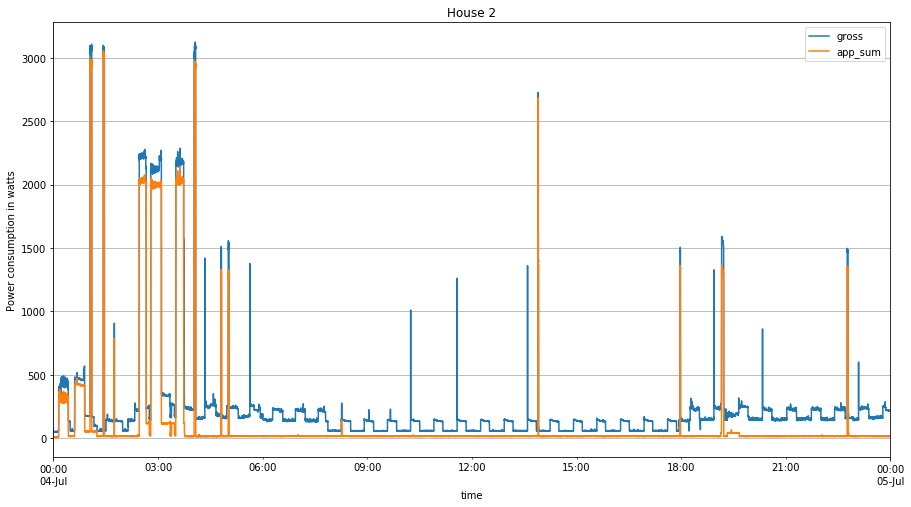

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = sub_df[['gross', 'app_sum']].plot(ax=ax)
ax.grid(True)
ax.set_title('House 2')
ax.set_ylabel('Power consumption in watts')

# Determine ON/OFF
When is each appliance on or off?  The blog notes:  
  
_We assume an appliance to be “on” if its power consumption is larger than one standard deviation from the sample mean of its power readings, given the fact that appliances are off most of the time and hence most of the readings are near zero._  
  
This part of the code creates columns for each appliance with the suffix _on .  Values are 1 if the power reading is > than the the standard deviation.  If it isn't, the value in the column is a zero.  This way, each appliance has a label column.

In [38]:
# @title Let's check out the std dev for each appliance
for i,app in enumerate(appliance_cols):
  sd = round(energy_data[app].std(),2)
  print('standard deviation for {} : {}W'.format(app,sd))


standard deviation for running_machine : 21.46W
standard deviation for washing_machine : 110.3W
standard deviation for dish_washer : 250.6W
standard deviation for microwave : 82.31W
standard deviation for toaster : 14.78W
standard deviation for kettle : 359.79W
standard deviation for rice_cooker : 26.9W
standard deviation for cooker : 5.02W


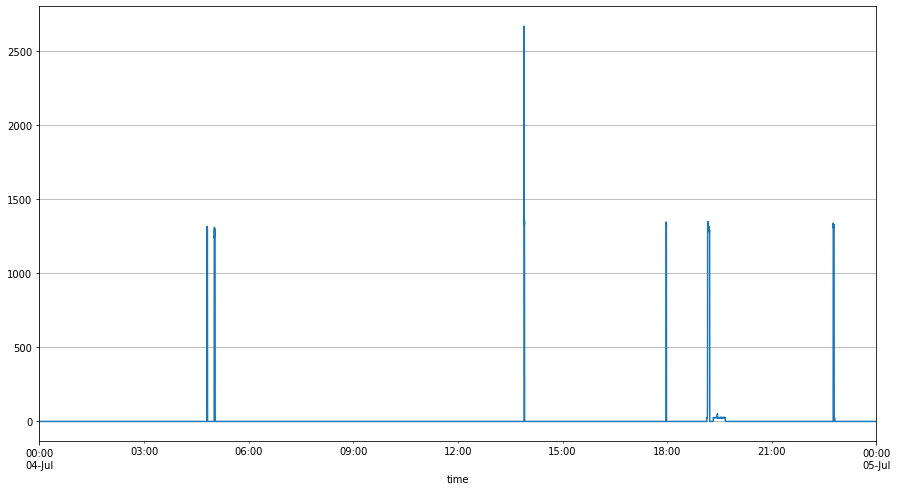

In [41]:
# @title zoom in on microwave readings
microwave = sub_df['microwave']
microwave.plot(figsize=(15, 8),grid=True)

At this resolution, it makes sense to use just the standard deviation as a cut off because it looks like there is a dramatic change from off to on.  However, looking more closely:

In [46]:
import datetime
now = datetime.datetime.now()
print(now.month)
now.day

11


17

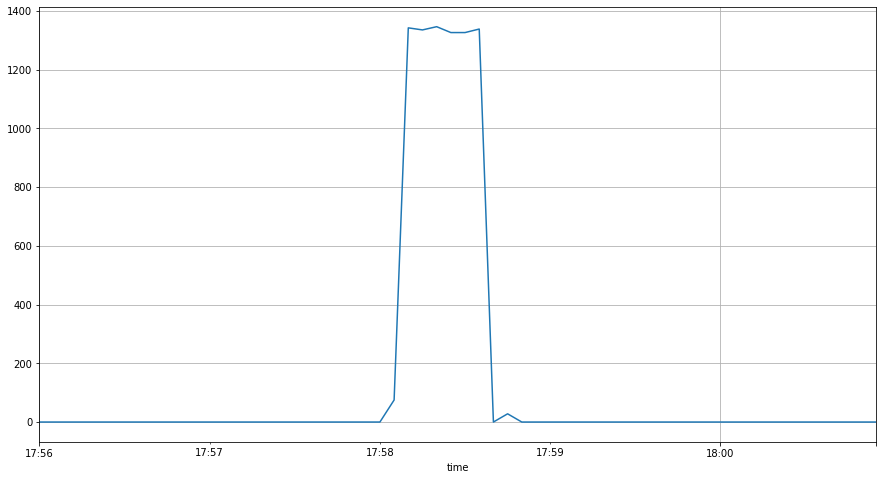

In [57]:
microwave['2013-07-04 17:56':'2013-07-04 18:00'].plot(figsize=(15, 8),grid=True)

part of the signature is lopped off.  For example, for the microwave reading that began at 5:58PM, there is a gradual rise in watts. Then prior to turning off, there is a slight bump in watts.  
  
Isn't this information important for training?

Also - would current and reactive power readings help "fine tune" the autodection of whether an appliance is on or off?

In [26]:
for i,app in enumerate(appliance_cols):
    lb = energy_data[app].std()
    ub = energy_data[app].max() - lb
    # energy_data[app + '_on'] = energy_data[app].apply(
    #   lambda x: 1 if x > lb else 0)
    print('standard deviation for {},{}:{}'.format(lb,ub,app))


standard deviation for 21.46307316104856,1327.5369268389513:running_machine
standard deviation for 110.30234098468421,2863.697659015316:washing_machine
standard deviation for 250.59622137658752,3704.4037786234126:dish_washer
standard deviation for 82.31060841636922,2585.689391583631:microwave
standard deviation for 14.776962580898735,3201.2230374191013:toaster
standard deviation for 359.7872983330898,3638.21270166691:kettle
standard deviation for 26.901424252362602,794.0985757476374:rice_cooker
standard deviation for 5.0220847945729,3526.977915205427:cooker


In [0]:

import numpy as np

In [0]:
nrow = int(np.ceil(np.sqrt(len(appliance_cols))))
ncol = int(np.ceil(1.0 * len(appliance_cols) / nrow))

In [66]:
len(appliance_cols)

8

In [70]:
nrow = np.ceil(np.sqrt(len(appliance_cols)))
nrow

3.0

In [74]:
ncol = int(np.ceil(len(appliance_cols) / nrow))
ncol

3

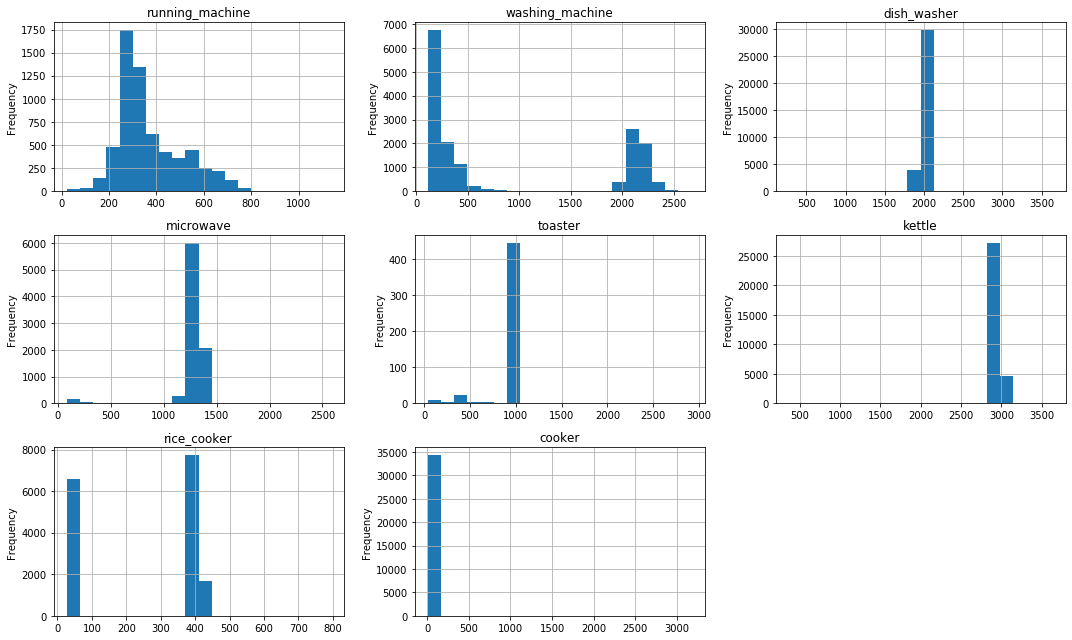

In [75]:
nrow = int(np.ceil(np.sqrt(len(appliance_cols))))
ncol = int(np.ceil(1.0 * len(appliance_cols) / nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(5*ncol, 3*nrow))
axes[-1, -1].axis('off')

for i, app in enumerate(appliance_cols):
  row_ix = i // 3
  col_ix = i % 3
  ax = axes[row_ix][col_ix]
  lb = energy_data[app].std()
  ub = energy_data[app].max() - lb
  energy_data[app + '_on'] = energy_data[app].apply(
      lambda x: 1 if x > lb else 0)
  energy_data[app][(energy_data[app] > lb) & 
                   (energy_data[app] < ub)].plot.hist(bins=20, ax=ax)
  ax.set_title(app)
  ax.grid(True)

plt.tight_layout()